# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader_fed
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

/home/zhiwen/Fed-Diffusion-TS/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting and Training

### Build dataset and settings

In [10]:
from Federated.horizontal.utils import load_partition
partition_id = 0
dataset = load_partition(
    "/home/zhiwen/Fed-Diffusion-TS/Data/datasets/labeled_stock_data.npy",
    partition_id=partition_id,
    nr_clients=3,
)
dataset.shape

(29328, 6)

In [11]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/stocks_hfl.yaml'
        self.save_dir = './toy_exp'
        self.gpu = 0
        self.client_id = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')
dl_info = build_dataloader_fed(configs, dataset, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

In [12]:
len(trainer.dataloader_info["dataset"])

1222

: 

### Training models

In [46]:
trainer.train()

  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.059248: 100%|██████████| 5/5 [00:00<00:00, 22.46it/s]

training complete


## Inference and Visualizations

### Sampling

In [33]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
# ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
ori_data = np.load(os.path.join(dataset.dir, f"stock_0_norm_truth_{seq_length}_train.npy"))  # Uncomment the line if dataset other than Sine is used.
fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_sines.npy'), fake_data)

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 500/500 [00:16<00:00, 30.65it/s]


In [54]:
dl_info['dataset'].name

'stock_0'

### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

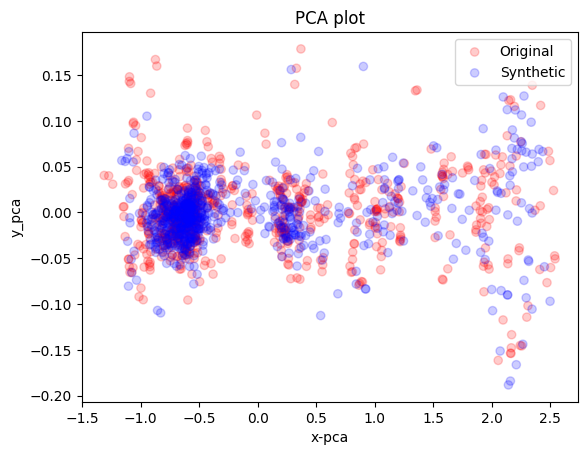

In [34]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1468 samples in 0.000s...
[t-SNE] Computed neighbors for 1468 samples in 0.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1468
[t-SNE] Computed conditional probabilities for sample 1468 / 1468
[t-SNE] Mean sigma: 0.027046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.213291
[t-SNE] KL divergence after 300 iterations: 0.586997


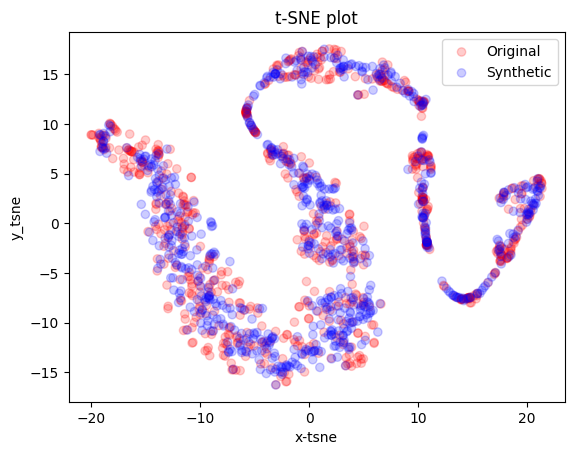

In [35]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

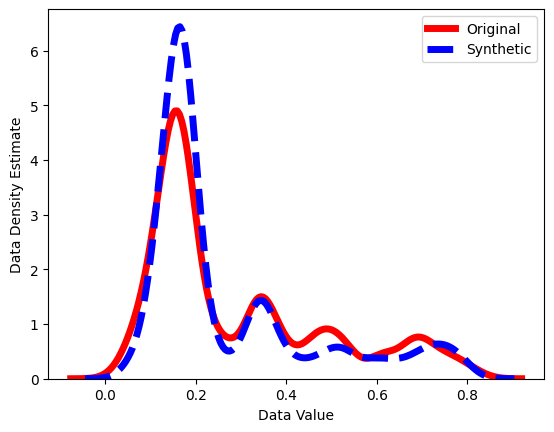

In [36]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])